# ОИАД. Лабораторная работа №3

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.base import RegressorMixin
import seaborn as sns
import matplotlib.pyplot as plt

   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
(1338, 7)
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64
age          0
bmi          4
children    18
charges      7
dtype: int64


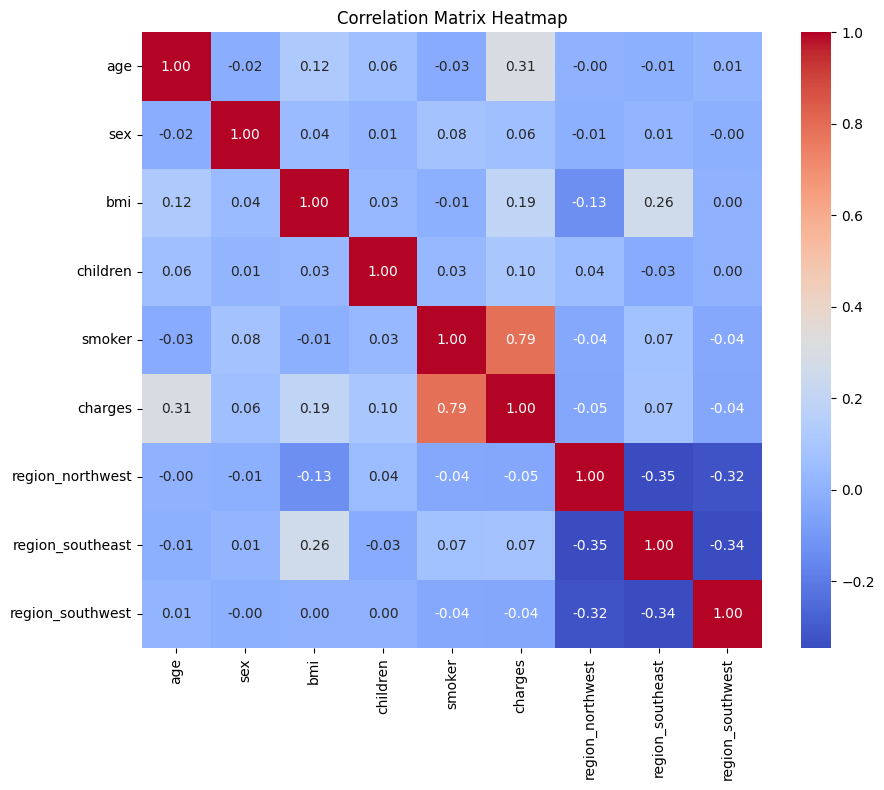

In [34]:
data = pd.read_csv("insurance.csv")
print(data.head())
print(data.shape)
print('===================')
print(data.isnull().sum())
print(data.isna().sum())
print('===================')
z_sc= (data.select_dtypes(np.number) - data.select_dtypes(np.number).mean()) / data.select_dtypes(np.number).std()
outl = (np.abs(z_sc) > 3).sum()
no_outliers = (np.abs(z_sc) <= 3).all(axis=1)
data = data[no_outliers].copy()
print(outl)
print('===================')
data['sex'] = data['sex'].map({'male': 1, 'female': 0})
data['smoker'] = data['smoker'].map({'yes': 1, 'no': 0})
data = pd.get_dummies(data, columns=['region'], drop_first=True)
corr = data.corr(numeric_only=True)
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix Heatmap")
plt.show()

# Regresion

In [35]:
Target="charges"
Y = data[Target].to_numpy(dtype=np.double)
X = data.drop(Target, axis=1).to_numpy(dtype=np.double)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

scaler = StandardScaler();
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [36]:
class Anreg(RegressorMixin):
    def fit(self, X, Y):
        X_b = np.column_stack([np.ones(X.shape[0]), X])
        w = np.linalg.inv(X_b.T @ X_b) @ X_b.T @ Y
        self.b = w[0]
        self.w = w[1:]
        return self

    def predict(self, X):
        return X @ self.w + self.b

Anreg1model = Anreg()
Anreg1model.fit(X_train, Y_train)
Y_pred = Anreg1model.predict(X_test)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

print("MSE train:", mse(Y_train, Anreg1model.predict(X_train)))
print("MSE test:", mse(Y_test, Y_pred))

rmse_train = rmse(Y_train, Anreg1model.predict(X_train))
rmse_test = rmse(Y_test, Y_pred)

print("RMSE train:", rmse_train)
print("RMSE test:", rmse_test)

MSE train: 34873610.1034764
MSE test: 30444091.52639578
RMSE train: 5905.388226313016
RMSE test: 5517.6164714843835


In [37]:
class LinReg(RegressorMixin):
    def __init__(self, lr=1e-3, epochs=5000, tol=1e-6, verbose=False):
        self.lr = lr
        self.epochs = epochs
        self.tol = tol
        self.verbose = verbose
        self.loss_history = []

    def fit(self, X, Y):
        X_b = np.column_stack([np.ones(X.shape[0]), X])
        n_features = X_b.shape[1]
        w = np.random.randn(n_features) * 0.01
        
        for i in range(self.epochs):
            y_pred = X_b @ w
            error = y_pred - Y
            grad = (2 / X_b.shape[0]) * (X_b.T @ error)
            w -= self.lr * grad
            mse = np.mean(error**2)
            self.loss_history.append(mse)
        
        self.b = w[0]
        self.w = w[1:]
        return self

    def predict(self, X):
        return X @ self.w + self.b

In [38]:
Linreg1model = LinReg(lr=1e-3, epochs=20000, tol=1e-6, verbose=True)
Linreg1model.fit(X_train, Y_train)

Y_pred_train = Linreg1model.predict(X_train)
Y_pred_test = Linreg1model.predict(X_test)
print("MSE train:", mse(Y_train, Y_pred_train))
print("MSE test:", mse(Y_test, Y_pred_test))
print("RMSE train:", rmse(Y_train, Y_pred_train))
print("RMSE test:", rmse(Y_test, Y_pred_test))

MSE train: 34873610.10347811
MSE test: 30444090.94488822
RMSE train: 5905.388226313162
RMSE test: 5517.6164187888435


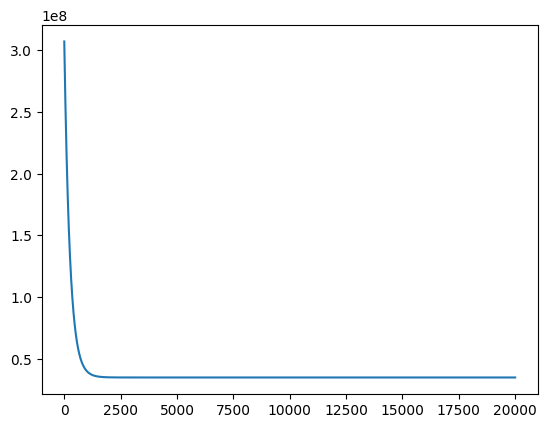

In [39]:
plt.plot(Linreg1model.loss_history)

In [40]:
class AnregRidge(RegressorMixin):
    def __init__(self, lmbd=1.0):
        self.lmbd = lmbd

    def fit(self, X, Y):
        X_b = np.column_stack([np.ones(X.shape[0]), X])
        n_features = X_b.shape[1]
        L = self.lmbd * np.eye(n_features)
        L[0, 0] = 0
        
        w = np.linalg.inv(X_b.T @ X_b + L) @ X_b.T @ Y
        self.b = w[0]
        self.w = w[1:]
        return self

    def predict(self, X):
        return X @ self.w + self.b


class LinRegRidge(RegressorMixin):
    def __init__(self, lr=1e-3, epochs=5000, lmbd=0.1, tol=1e-6, verbose=False):
        self.lr = lr
        self.epochs = epochs
        self.lmbd = lmbd
        self.tol = tol
        self.verbose = verbose
        self.loss_history = []

    def fit(self, X, Y):
        X_b = np.column_stack([np.ones(X.shape[0]), X])
        n_features = X_b.shape[1]
        w = np.random.randn(n_features) * 0.01
        for i in range(self.epochs):
            y_pred = X_b @ w
            error = y_pred - Y
            grad = (2 / X_b.shape[0]) * (X_b.T @ error)
            grad[1:] += 2 * self.lmbd * w[1:]
            
            w -= self.lr * grad
            
            mse = np.mean(error**2) + self.lmbd * np.sum(w[1:]**2)
            self.loss_history.append(mse)
        
        self.b = w[0]
        self.w = w[1:]
        return self

    def predict(self, X):
        return X @ self.w + self.b


In [41]:
Anreg2model = AnregRidge()
Anreg2model.fit(X_train, Y_train)
Y_pred = Anreg2model.predict(X_test)

def mse(y_true, y_pred):
    return np.mean((y_true - y_pred)**2)

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred) ** 2))

print("MSE train:", mse(Y_train, Anreg2model.predict(X_train)))
print("MSE test:", mse(Y_test, Y_pred))

rmse_train = rmse(Y_train, Anreg2model.predict(X_train))
rmse_test = rmse(Y_test, Y_pred)

print("RMSE train:", rmse_train)
print("RMSE test:", rmse_test)

MSE train: 34873706.539015
MSE test: 30444628.509259623
RMSE train: 5905.396391353844
RMSE test: 5517.665132033623


In [42]:
Linreg2model = LinRegRidge(lr=1e-3, epochs=20000, tol=1e-6, verbose=True)
Linreg2model.fit(X_train, Y_train)

Y_pred_train = Linreg2model.predict(X_train)
Y_pred_test = Linreg2model.predict(X_test)
print("MSE train:", mse(Y_train, Y_pred_train))
print("MSE test:", mse(Y_test, Y_pred_test))
print("RMSE train:", rmse(Y_train, Y_pred_train))
print("RMSE test :", rmse(Y_test, Y_pred_test))

MSE train: 35738814.852222025
MSE test: 31401415.12623114
RMSE train: 5978.194949332284
RMSE test : 5603.69655907876


In [43]:
class avg(RegressorMixin):
    def fit(self, X, Y):
        self.mean = np.mean(Y)
        return self
    
    def predict(self, X):
        return np.full(X.shape[0], self.mean)

In [44]:
Y_pred_linear = Anreg1model.predict(X_test)

Y_pred_ridge = Anreg2model.predict(X_test)

print("MSE test (linear):", mse(Y_test, Y_pred_linear))
print("MSE test (ridge):", mse(Y_test, Y_pred_ridge))

Y_pred_linear = Linreg1model.predict(X_test)

Y_pred_ridge = Linreg2model.predict(X_test)

print("MSE test (linear):", mse(Y_test, Y_pred_linear))
print("MSE test (ridge):", mse(Y_test, Y_pred_ridge))

model_avg = avg()
model_avg.fit(X_train, Y_train)
Y_pred_avg = model_avg.predict(X_test)

print("MSE test (constant):", mse(Y_test, Y_pred_avg))
# print("MSE test (linear):", mse(Y_test, Y_pred_linear))
# print("MSE test (ridge):", mse(Y_test, Y_pred_ridge))

MSE test (linear): 30444091.52639578
MSE test (ridge): 30444628.509259623
MSE test (linear): 30444090.94488822
MSE test (ridge): 31401415.12623114
MSE test (constant): 137709080.74319682


# Vivod
Пропусков в данных не обнаружено, выбросы удалены. Наибольшую положительную корреляцию с целевой переменной чарджес имеет признак курение — видимо курение сильно влияет на страховые выплаты. Аналитические и численные реализации линейной регрессии дали почти идентичные результаты. Регуляризация не дала сильных результатов, т.к. нет выраженной коллинеарности между признаками в совокупности. Базовая модель уступает, что подтверждает что написанные модели извлекают полезную информацию из признаков. Можно еще рассмотреть кросс вал для этой задачи.